# Koç University, Deep Learning Course (COMP541) <br/> Assignment 4: Graph Neural Networks and Transformers
In this assignment, you will implement the vanilla version of Graph Convolution
Networks (GCN) [Kipf and Welling \(2016\)](https://arxiv.org/abs/1609.02907) and Graph Attention Networks (GAT) [Veličković, et al.
\(2018\)](https://openreview.net/forum?id=rJXMpikCZ), as well as a transformer for translation.

## Background
### Basics of GCN
Recall from the lectures, the goal of a GCN is to learn a function of signals features on a graph $G = (V, E)$, which takes as inputs:
1. he input features of each node, $x_i ∈ R^F$ (in matrix form: $X ∈ R^{|V |×F}$ )
2. some information about the graph structure, typically the adjacency matrix $A$

Each convolutional layer can be written as $H^{(l+1)} = f(H^{(l)}, A)$ for some function $f$. The function $f$ we are using for this assignment is in the form of $f(H^{(l)}, A) = σ(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)})$, where $\hat{A} = A + I$ and $\hat{D}$ is the diagonal node degree matrix ($D^{-1}\hat{A}$ normalizes $\hat{A}$ such that all rows sum to one). Let $\tilde{A} = \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}$. The GCN we will implement takes two convolution layers, $Z = f(X, A) = softmax(\tilde{A}~.~Dropout(ReLU(\tilde{A}XW^{(0)}))~.W^{(1)})$

### Basics of GAT
Graph Attention Network (GAT) is a novel convolution-style neural network. It operates on graph-structured data and leverages masked self-attentional layers. In this assignment, we will implement the graph attention layer.

### Dataset
The dataset we used for this assignment is Cora ([Sen et al. \(2008\)](http://www.cs.iit.edu/~ml/pdfs/sen-aimag08.pdf)). Cora is one of standard citation network benchmark dataset (just like MNIST dataset for computer vision tasks). It that consists of 2708 scientific publications and 5429 links. Each publication is classified into one of 7 classes. Each publication is described by a word vector (length 1433) that indicates the absence/presence of the corresponding word. This is used as the features of each node for our experiment. The task is to perform node classification (predict which class each node belongs to).

# Google Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/comp541_assignment4_fall2025'
DIR = f'{BASE}/tr_to_en'


Mounted at /content/drive


In [2]:
import os

print(os.listdir(BASE))
print(os.listdir(DIR))

['.DS_Store', 'cora.tgz', 'tr_to_en', '.venv', 'cora', 'comp541_assignment4 (1).ipynb']
['tr.dev', 'tr.train.r0.125', 'en.train.r0.125', 'tr.train.r0.5', 'en.dev', 'tr.train', 'en.test', 'en.train.r0.5', 'en.train', 'tr.train.r0.25', 'en.train.r0.25', 'tr.test']


## Experiments
Experiments:
Open GCN notebook on Colab and implement the following parts.
1. Implementation of Graph Convolution Layer: Complete the code for `GraphConvolution` Class
2. Implementation of Graph Convolution Network: Complete the code for `GCN` Class
3. Train your Graph Convolution Network: After implementing the required classes, now you can train your GCN. We want you to play with the architecture (such as the number of Graph Convolution Layers, usage of Dropout etc.) and the hyperparameters, and report your results in various settings.
4. Implementation of Graph Attention Layer: Complete the code for `GraphAttentionLayer` Class
5. Train your Graph Convolution Network: After implementing the required classes, now you can train your GAT. Again, you are need to play with the structure and the hyperparameters and conduct various experiments.
6. Compare your models: Compare the evaluation results for Vanilla GCN and GAT. Comment on the discrepancy in their performance (if any) and briefly explain why you think it’s the case.

# Download the Cora data

In [3]:
!curl -O https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
! tar -zxvf cora.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  164k  100  164k    0     0  62124      0  0:00:02  0:00:02 --:--:-- 62126
cora/
cora/README
cora/cora.cites
cora/cora.content


# import modules and set random seed

In [4]:
import numpy as np
import scipy.sparse as sp
import torch
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading and preprocessing the data

In [ ]:
def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(path="cora/", dataset="cora", training_samples=140):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])
    adj = normalize_adj(adj)

    # Random indexes
    idx_rand = torch.randperm(len(labels))
    # Nodes for training
    idx_train = idx_rand[:training_samples]
    # Nodes for validation
    idx_val= idx_rand[training_samples:]

    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)

    return adj, features, labels, idx_train, idx_val

def normalize_adj(mx):
    """symmetric normalization"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

## Check the data

In [ ]:
adj, features, labels, idx_train, idx_val = load_data()

Loading cora dataset...


In [ ]:
print(adj)
print(adj.shape)

tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
torch.Size([2708, 2708])


In [ ]:
print(features)
print(features.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([2708, 1433])


In [ ]:
print(labels)
print(labels.unique())
print(len(labels))

tensor([2, 5, 4,  ..., 1, 0, 2])
tensor([0, 1, 2, 3, 4, 5, 6])
2708


In [ ]:
print(len(idx_train))
print(len(idx_val))

140
2568


# Part 1: Graph Attention Networks

## Part 1.1: Graph attention layer
A GAT is made up of multiple such layers. In this section, you will implement a single graph attention layer. Similar to the `GraphConvolution()`, this `GraphAttentionLayer()` module takes $\mathbf{h} = \{ \overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N} \}$ where $\overrightarrow{h_i} \in \mathbb{R}^F$ as input and outputs $\mathbf{h'} = \{ \overrightarrow{h'_1}, \overrightarrow{h'_2}, \dots, \overrightarrow{h'_N} \}$, where $\overrightarrow{h'_i} \in \mathbb{R}^{F'}$. However, instead of weighing each neighbouring node based on the adjacency matrix, we will use self attention to learn the relative importance of each neighbouring node. Recall from HW4 where you are asked to write out the equation for single headed attention, here we will implement multi-headed attention, which involves the following steps:


### The initial transformation
In GCN above, you have completed similar transformation. But here, we need to define a weight matrix and perform this transformation for each head: $\overrightarrow{s^k_i} = \mathbf{W}^k \overrightarrow{h_i}$. We will perform a single linear transformation and then split it up for each head later. Note the input $\overrightarrow{h}$ has shape `[n_nodes, in_features]` and $\overrightarrow{s}$ has shape of `[n_nodes, n_heads * n_hidden]`. Remember to reshape $\overrightarrow{s}$ has shape of `[n_nodes, n_heads, n_hidden]` for later uses. Note: set `bias=False` for this linear transformation.

### attention score
We calculate these for each head $k$. Here for simplicity of the notation, we omit $k$ in the following equations. The attention scores are defined as the follows:
$e_{ij} = a(\mathbf{W} \overrightarrow{h_i}, \mathbf{W} \overrightarrow{h_j}) =a(\overrightarrow{s_i}, \overrightarrow{s_j})$,
where $e_{ij}$ is the attention score (importance) of node $j$ to node $i$.
We will have to calculate this for each head. $a$ is the attention mechanism, that calculates the attention score. The paper concatenates $\overrightarrow{s_i}$, $\overrightarrow{s_j}$ and does a linear transformation with a weight vector $\mathbf{a} \in \mathbb{R}^{2 F'}$ followed by a $\text{LeakyReLU}$. $$e_{ij} = \text{LeakyReLU} \Big(
\mathbf{a}^\top \Big[ \overrightarrow{s_i} \Vert \overrightarrow{s_j}  \Big] \Big)$$

#### How to vectorize this? Some hints:
1. `tensor.repeat()` gives you $\{\overrightarrow{s_1}, \overrightarrow{s_2}, \dots, \overrightarrow{s_N}, \overrightarrow{s_1}, \overrightarrow{s_2}, \dots, \overrightarrow{s_N}, ...\}$.

2. `tensor.repeat_interleave()` gives you
$\{\overrightarrow{s_1}, \overrightarrow{s_1}, \dots, \overrightarrow{s_1}, \overrightarrow{s_2}, \overrightarrow{s_2}, \dots, \overrightarrow{s_2}, ...\}$.

3. concatenate to get $\Big[\overrightarrow{s_i} \Vert \overrightarrow{s_j} \Big]$ for all pairs of $i, j$. Reshape $\overrightarrow{s_i} \Vert \overrightarrow{s_j}$ has shape of `[n_nodes, n_nodes, n_heads, 2 * n_hidden]`

4. apply the attention layer and non-linear activation function to get $e_{ij} = \text{LeakyReLU} \Big( \mathbf{a}^\top \Big[ \overrightarrow{s_i} \Vert \overrightarrow{s_j}  \Big] \Big)$, where $\mathbf{a}^\top$ is a single linear transformation that maps from dimension `n_hidden * 2` to `1`. Note: set the `bias=False` for this linear transformation. $\mathbf{e}$ is of shape `[n_nodes, n_nodes, n_heads, 1]`. Remove the last dimension `1` using `squeeze()`.


#### Perform softmax
First, we need to mask $e_{ij}$ based on adjacency matrix. We only need to sum over the neighbouring nodes for the attention calculation. Set the elements in $e_{ij}$ to $- \infty$ if there is no edge from $i$ to $j$ for the softmax calculation. We need to do this for all heads and the adjacency matrix is the same for each head. Use `tensor.masked_fill()` to mask $e_{ij}$ based on adjacency matrix for all heads. Hint: reshape the adjacency matrix to `[n_nodes, n_nodes, 1]` using `unsqueeze()`.
Now we are ready to normalize attention scores (or coefficients) $$\alpha_{ij} = \text{softmax}_j(e_{ij}) =  \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}$$

#### Apply dropout
Apply the dropout layer. (this step is easy)

#### Calculate final output for each head
$$\overrightarrow{h'^k_i} = \sum_{j \in \mathcal{N}_i} \alpha^k_{ij} \overrightarrow{s^k_j}$$


#### Concat or Mean
Finally we concateneate the transformed features: $\overrightarrow{h'_i} = \Bigg\Vert_{k=1}^{K} \overrightarrow{h'^k_i}$. In the code, we only need to reshape the tensor to shape of `[n_nodes, n_heads * n_hidden]`. Note that if it is the final layer, then it doesn't make sense to do concatenation anymore. Instead, we sum over the `n_heads` dimension: $\overrightarrow{h'_i} = \frac{1}{K} \sum_{k=1}^{K} \overrightarrow{h'^k_i}$.

In [ ]:
class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features: int, out_features: int, n_heads: int,
                 is_concat: bool = True,
                 dropout: float = 0.6,
                 alpha: float = 0.2):
        """
        in_features: F, the number of input features per node
        out_features: F', the number of output features per node
        n_heads: K, the number of attention heads
        is_concat: whether the multi-head results should be concatenated or averaged
        dropout: the dropout probability
        alpha: the negative slope for leaky relu activation
        """
        super(GraphAttentionLayer, self).__init__()

        self.is_concat = is_concat
        self.n_heads = n_heads

        if is_concat:
            assert out_features % n_heads == 0
            self.n_hidden = out_features // n_heads
        else:
            self.n_hidden = out_features

        # TODO: initialize the following modules:
        # (1) self.W: Linear layer that transform the input feature before self attention.
        # You should NOT use for loops for the multiheaded implementation (set bias = Flase)
        # (2) self.attention: Linear layer that compute the attention score (set bias = Flase)
        # (3) self.activation: Activation function (LeakyReLU whith negative_slope=alpha)
        # (4) self.softmax: Softmax function (what's the dim to compute the summation?)
        # (5) self.dropout_layer: Dropout function(with ratio=dropout)
        ################ your code here ########################
        self.W = nn.Linear(in_features, n_heads * self.n_hidden, bias=False)
        self.attention = nn.Linear(2 * self.n_hidden, 1, bias=False)
        self.activation = nn.LeakyReLU(negative_slope=alpha)
        self.softmax = nn.Softmax(dim=1)
        self.dropout_layer = nn.Dropout(p=dropout)




        ########################################################

    def forward(self, h: torch.Tensor, adj_mat: torch.Tensor):
        # Number of nodes
        n_nodes = h.shape[0]

        # TODO:
        # (1) calculate s = Wh and reshape it to [n_nodes, n_heads, n_hidden]
        #     (you can use tensor.view() function)
        # (2) get [s_i || s_j] using tensor.repeat(), repeat_interleave(), torch.cat(), tensor.view()
        # (3) apply the attention layer
        # (4) apply the activation layer (you will get the attention score e)
        # (5) remove the last dimension 1 use tensor.squeeze()
        # (6) mask the attention score with the adjacency matrix (if there's no edge, assign it to -inf)
        #     note: check the dimensions of e and your adjacency matrix. You may need to use the function unsqueeze()
        # (7) apply softmax
        # (8) apply dropout_layer
        ############## Your code here #########################################
        s = self.W(h)
        s = s.view(n_nodes, self.n_heads, self.n_hidden)
        s_i = s.repeat_interleave(n_nodes, dim=0)
        s_i = s_i.view(n_nodes, n_nodes, self.n_heads, self.n_hidden)
        s_j = s.repeat(n_nodes, 1, 1)
        s_j = s_j.view(n_nodes, n_nodes, self.n_heads, self.n_hidden)
        s_cat = torch.cat([s_i, s_j], dim=-1)
        e = self.attention(s_cat)
        e = self.activation(e)
        e = e.squeeze(-1)
        mask = adj_mat.unsqueeze(-1)
        e = e.masked_fill(mask == 0, float('-inf'))
        a = self.softmax(e)
        a = self.dropout_layer(a)


        #######################################################################

        # Summation
        h_prime = torch.einsum('ijh,jhf->ihf', a, s) #[n_nodes, n_heads, n_hidden]


        # TODO: Concat or Mean
        # Concatenate the heads
        if self.is_concat:
            ############## Your code here #########################################
            h_prime = h_prime.reshape(n_nodes, self.n_heads * self.n_hidden)

            #######################################################################
        # Take the mean of the heads (for the last layer)
        else:
            ############## Your code here #########################################
            h_prime = h_prime.mean(dim=1)


            #######################################################################

        return h_prime





## Part 1.2: Define GAT network
it's really similar to how we defined GCN. You can follow the paper to set the number of attention layers and the activation function

In [ ]:
class GAT(nn.Module):

    def __init__(self, nfeat: int, n_hidden: int, n_classes: int, n_heads: int, dropout: float, alpha: float):
        """
        in_features: the number of features per node
        n_hidden: the number of features in the first graph attention layer
        n_classes: the number of classes
        n_heads: the number of heads in the graph attention layers
        dropout: the dropout probability
        alpha: the negative input slope for leaky ReLU of the attention layer
        """
        super().__init__()

        # TODO: Set your GraphAttentionLayers, activation function and possibly extensions (such as Dropout)
        self.dropout = dropout

        self.layer1 = GraphAttentionLayer(
            in_features=nfeat,
            out_features=n_hidden,
            n_heads=n_heads,
            is_concat=True,
            dropout=dropout,
            alpha=alpha
        )

        self.elu = nn.ELU()

        self.layer2 = GraphAttentionLayer(
            in_features=n_hidden,
            out_features=n_classes,
            n_heads=n_heads,
            is_concat=False,
            dropout=dropout,
            alpha=alpha
        )

        self.dropout_layer = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, adj_mat: torch.Tensor):
        """
        x: the features vectors
        adj_mat: the adjacency matrix
        """
        # TODO: implement the forward function
        x = self.dropout_layer(x)
        x = self.layer1(x, adj_mat)
        x = self.elu(x)
        x = self.dropout_layer(x)
        x = self.layer2(x, adj_mat)
        x = F.log_softmax(x, dim=1)
        return x


## Part 1.3: Training GAT

Play with the structure and the experiment settings and report your results as stated.

In [ ]:
# TODO: SET YOUR HYPERPARAMETERS HERE
args = {
    "training_samples": 140,
    "epochs": 1000,
    "lr": 0.005,
    "weight_decay": 0.0005,
    "dropout": 0.6,
    "n_heads": 8,
    "n_hidden": 8,
    "alpha": 0.2,
    "n_classes": 7,
}

In [ ]:
# TODO: SET YOUR MODE AND OPTIMIZER HERE
model = GAT(
    nfeat=features.shape[1],
    n_hidden=args["n_hidden"],
    n_classes=args["n_classes"],
    n_heads=args["n_heads"],
    dropout=args["dropout"],
    alpha=args["alpha"]
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=args["lr"],
    weight_decay=args["weight_decay"]
)

criterion = nn.CrossEntropyLoss()


adj, features, labels, idx_train, idx_val = load_data(training_samples=args["training_samples"])
adj, features, labels, idx_train, idx_val = adj.to(device), features.to(device), labels.to(device), idx_train.to(device), idx_val.to(device)

Loading cora dataset...


In [ ]:
def train(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    train_loss = criterion(output[idx_train], labels[idx_train])
    train_acc = accuracy(output[idx_train], labels[idx_train])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        output_validation = model(features, adj)
        validation_loss = criterion(output_validation[idx_val], labels[idx_val])
        validation_acc = accuracy(output_validation[idx_val], labels[idx_val])

    print(f"Epoch {epoch+1}/{args['epochs']}, Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc.item():.4f}, Validation Loss: {validation_loss.item():.4f}, Validation Acc: {validation_acc.item():.4f}")


def test():
    model.eval()
    output = model(features, adj)
    test_loss = criterion(output[idx_val], labels[idx_val])
    test_acc = accuracy(output[idx_val], labels[idx_val])
    preds = output[idx_val].argmax(dim=1)

    print(f"Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc.item():.4f}")
    return test_loss.item(), test_acc.item(), preds


In [ ]:
# Train model
t_total = time.time()
for epoch in range(args["epochs"]):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

Epoch 1/1000, Train Loss: 1.9460, Train Acc: 0.1929, Validation Loss: 1.9457, Validation Acc: 0.3092
Epoch 2/1000, Train Loss: 1.9456, Train Acc: 0.1500, Validation Loss: 1.9455, Validation Acc: 0.3820
Epoch 3/1000, Train Loss: 1.9454, Train Acc: 0.2214, Validation Loss: 1.9453, Validation Acc: 0.3851
Epoch 4/1000, Train Loss: 1.9449, Train Acc: 0.2786, Validation Loss: 1.9451, Validation Acc: 0.3843
Epoch 5/1000, Train Loss: 1.9449, Train Acc: 0.2786, Validation Loss: 1.9449, Validation Acc: 0.3773
Epoch 6/1000, Train Loss: 1.9442, Train Acc: 0.3500, Validation Loss: 1.9446, Validation Acc: 0.3610
Epoch 7/1000, Train Loss: 1.9440, Train Acc: 0.3071, Validation Loss: 1.9444, Validation Acc: 0.3462
Epoch 8/1000, Train Loss: 1.9435, Train Acc: 0.3857, Validation Loss: 1.9441, Validation Acc: 0.3396
Epoch 9/1000, Train Loss: 1.9432, Train Acc: 0.3429, Validation Loss: 1.9438, Validation Acc: 0.3361
Epoch 10/1000, Train Loss: 1.9429, Train Acc: 0.3357, Validation Loss: 1.9435, Validation A

(1.0474703311920166,
 0.7784267912772586,
 tensor([0, 4, 1,  ..., 6, 4, 2], device='cuda:0'))

# Question: (Your task)
Compare the evaluation results for Vanilla GCN (from the tutorial session) and GAT. Comment on the discrepancy in their performance (if any) and briefly explain why you think it's the case.

**Your answer here:**

### Comparison of Accuracies:

* Vanilla GCN: Achieved 70.33% accuracy on test set.
* GAT: Achieved **77.84%** accuracy on test set.

### Comments:

GAT clearly outperforms vanilla GCN by 7.5%. The reason for this is the attention mechanism that GAT uses. GAT assigns different values to different neigbours of a node and uses the important neighbours and ignores the others. On the other hand, vanilla GCN treats all the neighbours same because it uses fixed weights based on the graph structure. This attention mechanism helps GAT to capture more complex patterns.


## Part 2: Transformers

In the tutorial session, you learned how to use a transformer model for language modeling. This is a type of decoder-only model, where we directly use the input embeddings to generate text. Here, we will focus on a different task instead: translation. To do this, we will need to use an encoder-decoder architecture.

### Part 2.1: Transformer Layers

Here, you will need to implement a few different layers.
1) A multi-head attention block.
2) A feedforward network.
3) A positional encoding (in the tutorial we used a learned positional encoding. In this assignment, you should implement a sinusoidal positional encoding).

***Note that the template code provided for you below is only a template, and you may modify the parameters for the functions as needed.***

Once you have these, you will need to combine them together into an encoder and a decoder. Each of these should have $N$ sets of multi-head attention + feedforward. However, the encoder and decoder have to be implemented slightly differently, as the decoder requires masking.

Additionally, since this is a translation task, we will need two sets of word embeddings (the input embeddings corresponding to the starting language, and the output embeddings corresponding to the translated language).

#### Multi-Head Attention
Multi-head attention should be implemented slightly differently here, compared to the tutorial. Specifically, your multi-head attention implementation should allow for masking. This means that if an input mask is provided, everything that is masked out (a value of $0$ in the mask) should not contribute to the attention calculations.

It is crucial that the decoder is properly masked. This is because we do not want to allow the decoder to apply attention to output positions it has not seen yet.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dimension, hidden_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.query = nn.Linear(input_dimension, hidden_dim)
        self.key = nn.Linear(input_dimension, hidden_dim)
        self.value = nn.Linear(input_dimension, hidden_dim)
        self.out = nn.Linear(hidden_dim, input_dimension)

    def forward(self, x, context=None, mask=None, return_attn=False):

        B, T, C = x.shape

        q = self.query(x)
        k = self.key(context)
        v = self.value(context)

        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(attention_scores, dim=-1)
        self.last_attention_weights = attention_weights.detach()

        out = torch.matmul(attention_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, T, -1)
        out = self.out(out)

        if return_attn:
            return out, attention_weights
        return out

class FeedForward(nn.Module):
    def __init__(self, input_dimension, hidden_dim, output_dim, n_layers, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()
        if n_layers == 1:
            self.layers.append(nn.Linear(input_dimension, output_dim))
        else:
            self.layers.append(nn.Linear(input_dimension, hidden_dim))
            for _ in range(n_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
                x = self.dropout(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=5000):
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2) * (-math.log(10000.0) / hidden_dim))
        positional_encoding = torch.zeros(max_len, hidden_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
       return x + self.positional_encoding[:x.size(1)]


In [63]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super().__init__()
        # TODO
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                "attention": MultiHeadAttention(input_dim, hidden_dim, num_heads),
                "feedforward": FeedForward(input_dim, hidden_dim * 4, input_dim, n_layers=2, dropout=dropout),
                "norm1": nn.LayerNorm(input_dim),
                "norm2": nn.LayerNorm(input_dim),
                "dropout": nn.Dropout(dropout)
            })
            for _ in range(num_layers)
        ])
        self.positional_encoding = PositionalEncoding(input_dim)

    def forward(self, x, mask=None, return_attn_maps=False):
        # TODO
        x = self.positional_encoding(x)
        attn_maps = []
        for layer in self.layers:
            if return_attn_maps:
                attention_output, attn = layer["attention"](x, context=None, mask=mask, return_attn=True)
                attn_maps.append(attn)
            else:
                attention_output = layer["attention"](x, context=None, mask=mask)
            x = layer["norm1"](x + layer["dropout"](attention_output))

            feedforward_output = layer["feedforward"](x)
            x = layer["norm2"](x + feedforward_output)

        if return_attn_maps:
            return x, attn_maps
        return x


class TransformerDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                "self_attention": MultiHeadAttention(input_dim, hidden_dim, num_heads),
                "cross_attention": MultiHeadAttention(input_dim, hidden_dim, num_heads),
                "feedforward": FeedForward(input_dim, hidden_dim * 4, input_dim, n_layers=2, dropout=dropout),
                "norm1": nn.LayerNorm(input_dim),
                "norm2": nn.LayerNorm(input_dim),
                "norm3": nn.LayerNorm(input_dim),
                "dropout": nn.Dropout(dropout)
            })
            for _ in range(num_layers)
        ])
        self.positional_encoding = PositionalEncoding(input_dim)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None, return_attn_maps=False):
        x = self.positional_encoding(x)
        self_attn_maps = []
        for layer in self.layers:

            if return_attn_maps:
                self_attention_output, self_attn = layer["self_attention"](x, context=None, mask=tgt_mask, return_attn=True)
                self_attn_maps.append(self_attn)
            else:
                self_attention_output = layer["self_attention"](x, context=None, mask=tgt_mask)
            x = layer["norm1"](x + layer["dropout"](self_attention_output))

            cross_attention_output = layer["cross_attention"](x, context=encoder_output, mask=src_mask)
            x = layer["norm2"](x + layer["dropout"](cross_attention_output))

            feedforward_output = layer["feedforward"](x)
            x = layer["norm3"](x + feedforward_output)

        if return_attn_maps:
            return x, self_attn_maps
        return x


In [64]:
class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.src_embedding = nn.Embedding(input_dim, hidden_dim)
        self.tgt_embedding = nn.Embedding(output_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)


        self.encoder = TransformerEncoder(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            output_dim=hidden_dim,
            dropout=dropout
        )
        self.decoder = TransformerDecoder(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            output_dim=hidden_dim,
            dropout=dropout
        )


        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, return_attn_maps=False):
        src_emb = self.src_embedding(src) * math.sqrt(self.hidden_dim)
        src_emb = self.dropout(src_emb)

        encoder_output = self.encoder(src_emb, src_mask)
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.hidden_dim)
        tgt_emb = self.dropout(tgt_emb)

        if return_attn_maps:
            decoder_output, decoder_self_attn = self.decoder(
                tgt_emb, encoder_output, src_mask, tgt_mask, return_attn_maps=True
            )
        else:
            decoder_output = self.decoder(tgt_emb, encoder_output, src_mask, tgt_mask)

        output = self.output_layer(decoder_output)

        if return_attn_maps:
            return output, {"decoder_self": decoder_self_attn}
        return output

### Part 2.2: Training the Transformer

We will be training our transformer on English -> Turkish translation. In the provided dataset, there are files labeled `{language}.{split}`, for example `en.train`. These are paired data, meaning that each line in the english file has the corresponding translation in the turkish file. There are also 0.5, 0.25, and 0.125 files, which correspond to smaller versions of the training data. Based on training times you encounter, you can use the smaller versions if needed.

As with the language modeling task, the model will output logits for each word, which you will then use for the loss.

#### Setting up the Data

Here, we will use word tokens, similar to the RNN assignment. However, you will need to have two sets of tokens, one for the starting language and one for the ending language. You are free to copy the data loading code from assignment 3 and make the necessary modifications, or you may implement the data loading in your own way. However, since we are no longer using fixed length sentences, you will need to implement padding (recall assignment 1).

In [65]:
import os
import os
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

PAD_TOKEN = "<PAD>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

In [66]:
class Vocabulary:
    def __init__(self, min_freq=1):
        self.word2idx = {PAD_TOKEN: PAD_IDX, SOS_TOKEN: SOS_IDX, EOS_TOKEN: EOS_IDX, UNK_TOKEN: UNK_IDX}
        self.idx2word = {PAD_IDX: PAD_TOKEN, SOS_IDX: SOS_TOKEN, EOS_IDX: EOS_TOKEN, UNK_IDX: UNK_TOKEN}
        self.word_count = Counter()
        self.min_freq = min_freq

    def build_vocab(self, sentences):
        for sentence in sentences:
            self.word_count.update(sentence)

        for word, count in self.word_count.items():
            if count >= self.min_freq and word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

    def __len__(self):
        return len(self.word2idx)

    def encode(self, sentence):
        return [SOS_IDX] + [self.word2idx.get(word, UNK_IDX) for word in sentence] + [EOS_IDX]

    def decode(self, indices):
        return [self.idx2word.get(idx, UNK_TOKEN) for idx in indices]

In [67]:
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = self.src_vocab.encode(self.src_sentences[idx])
        tgt = self.tgt_vocab.encode(self.tgt_sentences[idx])
        return torch.tensor(src), torch.tensor(tgt)

In [68]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)

    return src_padded, tgt_padded

def load_sentences(filepath):
    sentences = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().lower().split()
            if tokens:
                sentences.append(tokens)
    return sentences

def load_data(base_dir, suffix=""):
    en_train = load_sentences(os.path.join(base_dir, f"en.train{suffix}"))
    tr_train = load_sentences(os.path.join(base_dir, f"tr.train{suffix}"))
    en_dev = load_sentences(os.path.join(base_dir, "en.dev"))
    tr_dev = load_sentences(os.path.join(base_dir, "tr.dev"))
    en_test = load_sentences(os.path.join(base_dir, "en.test"))
    tr_test = load_sentences(os.path.join(base_dir, "tr.test"))

    en_vocab = Vocabulary(min_freq=2)
    tr_vocab = Vocabulary(min_freq=2)
    en_vocab.build_vocab(en_train)
    tr_vocab.build_vocab(tr_train)

    print(f"English vocabulary size: {len(en_vocab)}")
    print(f"Turkish vocabulary size: {len(tr_vocab)}")
    print(f"Training samples: {len(en_train)}")
    print(f"Validation samples: {len(en_dev)}")
    print(f"Test samples: {len(en_test)}")

    train_dataset = TranslationDataset(tr_train, en_train, tr_vocab, en_vocab)
    dev_dataset = TranslationDataset(tr_dev, en_dev, tr_vocab, en_vocab)
    test_dataset = TranslationDataset(tr_test, en_test, tr_vocab, en_vocab)

    return train_dataset, dev_dataset, test_dataset, en_vocab, tr_vocab

In [69]:
train_dataset, dev_dataset, test_dataset, en_vocab, tr_vocab = load_data(DIR, suffix=".r0.125")

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

English vocabulary size: 11541
Turkish vocabulary size: 20531
Training samples: 22806
Validation samples: 4045
Test samples: 5029


#### Training the Model

To train the model, you can use a similar approach to the tutorial. However, to calculate the loss, you will need both the source and target language tokens.

You should test with multiple sets of hyperparameters and provide the values and results of the best set on the validation data. For this, you should implement a function to calculate the accuracy.

In [70]:
def create_masks(src, tgt):
    src_mask = (src != PAD_IDX).unsqueeze(1).unsqueeze(2)
    tgt_pad_mask = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(2)

    tgt_len = tgt.size(1)
    causal_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=tgt.device)).bool()
    causal_mask = causal_mask.unsqueeze(0).unsqueeze(1)

    tgt_mask = torch.logical_and(tgt_pad_mask, causal_mask)

    return src_mask, tgt_mask

In [71]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask, tgt_mask = create_masks(src, tgt_input)

        optimizer.zero_grad()

        output = model(src, tgt_input, src_mask, tgt_mask)

        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

        predictions = output.argmax(dim=-1)
        mask = tgt_output != PAD_IDX
        correct += ((predictions == tgt_output) & mask).sum().item()
        total += mask.sum().item()

    accuracy = correct / total if total > 0 else 0
    return total_loss / len(train_loader), accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_mask, tgt_mask = create_masks(src, tgt_input)

            output = model(src, tgt_input, src_mask, tgt_mask)

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt_output = tgt_output.contiguous().view(-1)

            loss = criterion(output, tgt_output)
            total_loss += loss.item()

            predictions = output.argmax(dim=-1)
            mask = tgt_output != PAD_IDX
            correct += ((predictions == tgt_output) & mask).sum().item()
            total += mask.sum().item()

    accuracy = correct / total if total > 0 else 0
    return total_loss / len(data_loader), accuracy


HIDDEN_DIM = 256
NUM_HEADS = 4
NUM_LAYERS = 3
DROPOUT = 0.1
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

model = Transformer(
    input_dim=len(tr_vocab),
    hidden_dim=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    output_dim=len(en_vocab),
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc= train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, dev_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Time: {elapsed:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1/20 | Time: 37.7s
  Train Loss: 5.1363 | Train Accuracy: 0.2101
  Val Loss: 4.5223 | Val Accuracy: 0.2559
Epoch 2/20 | Time: 39.2s
  Train Loss: 4.4970 | Train Accuracy: 0.2587
  Val Loss: 4.3134 | Val Accuracy: 0.2780
Epoch 3/20 | Time: 38.1s
  Train Loss: 4.1890 | Train Accuracy: 0.2810
  Val Loss: 4.1561 | Val Accuracy: 0.2983
Epoch 4/20 | Time: 38.7s
  Train Loss: 3.9330 | Train Accuracy: 0.2990
  Val Loss: 4.0944 | Val Accuracy: 0.3076
Epoch 5/20 | Time: 38.5s
  Train Loss: 3.7022 | Train Accuracy: 0.3149
  Val Loss: 4.0748 | Val Accuracy: 0.3123
Epoch 6/20 | Time: 38.4s
  Train Loss: 3.4852 | Train Accuracy: 0.3303
  Val Loss: 4.0578 | Val Accuracy: 0.3217
Epoch 7/20 | Time: 38.6s
  Train Loss: 3.2888 | Train Accuracy: 0.3462
  Val Loss: 4.1045 | Val Accuracy: 0.3156
Epoch 8/20 | Time: 38.7s
  Train Loss: 3.1053 | Train Accuracy: 0.3622
  Val Loss: 4.1423 | Val Accuracy: 0.3217
Epoch 9/20 | Time: 38.5s
  Train Loss: 2.9362 | Train Accuracy: 0.3807
  Val Loss: 4.1905 | Val 

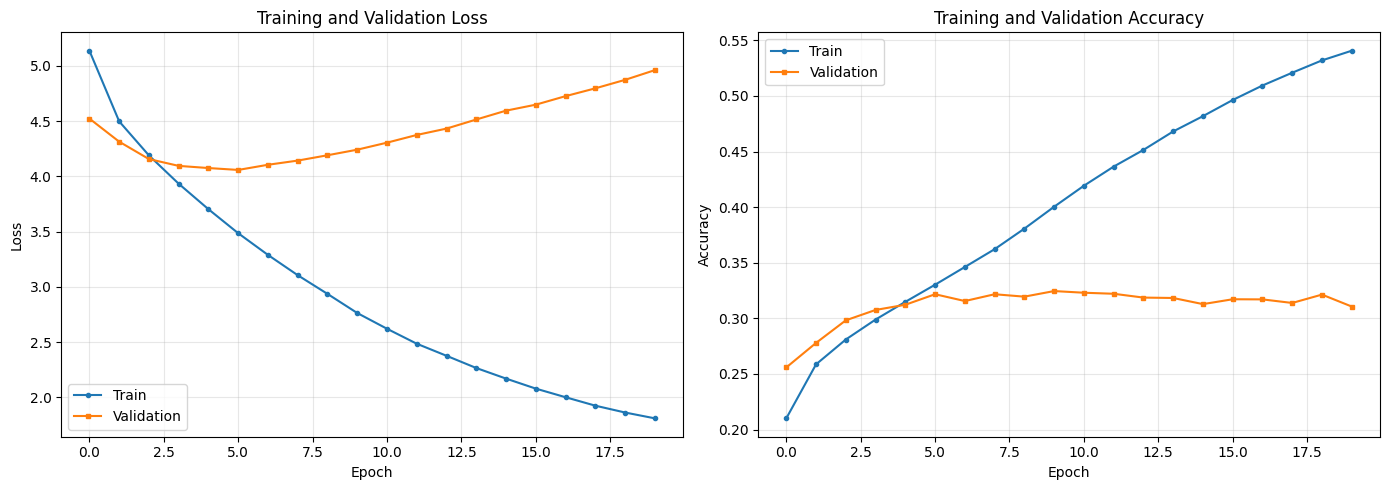

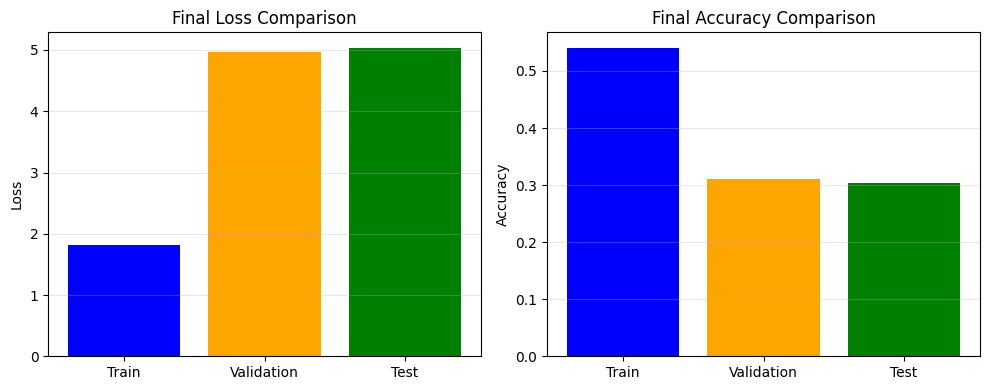

Test Loss: 5.0363 | Test Accuracy: 0.3043


In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train', marker='o', markersize=3)
axes[0].plot(val_losses, label='Validation', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training and Validation Loss')
axes[0].grid(True, alpha=0.3)


axes[1].plot(train_accuracies, label='Train', marker='o', markersize=3)
axes[1].plot(val_accuracies, label='Validation', marker='s', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Training and Validation Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(['Train', 'Validation', 'Test'],
            [train_losses[-1], val_losses[-1], test_loss],
            color=['blue', 'orange', 'green'])
axes[0].set_ylabel('Loss')
axes[0].set_title('Final Loss Comparison')
axes[0].grid(True, alpha=0.3, axis='y')


axes[1].bar(['Train', 'Validation', 'Test'],
            [train_accuracies[-1], val_accuracies[-1], test_acc],
            color=['blue', 'orange', 'green'])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Final Accuracy Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


### Experiment 1 (training with small dataset and experimenting with different hyperparameters) :

I first tried to train the model with small dataset (r0.0125). The hyperparameters that I've used to train were like this:

* hidden_dim = 256
* num_layers = 3
* num_heads = 4
* dropout = 0.1
* learning = 0.001
* batch = 64
* epochs = 20

The results I've got is like this:

| Dataset | Epochs | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc |
|---|---:|---:|---:|---:|---:|---:|---:|
| r0.125 | 20 | 1.77 | 0.55 | 5.11 | 0.31 | 5.1104 | 0.3061 |

* Training loss and accuracy improved over epochs, but validation plateaued around apporixametaly 31-32%.

* Validation loss started to increase after early epochs, this indicates that model overfits on a small dataset.

---
I also decided to experiment with different hyperparameters:

1) I've trained the model longer (30 epochs). The results are like this:

| Dataset | Epochs | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc |
|---|---:|---:|---:|---:|---:|---:|---:|
| r0.125 | 30 | 1.3638 | 0.6264 | 5.5324 | 0.3039 | 5.6142 | 0.2982 |

* Longer training improved training accuracy (from 0.55 to 0.63), but validation accuracy did not improve and test accuracy slightly dropped.
* Validation loss kept increasing after the early epochs, which again confirms overfitting on the small dataset.
* Best validation accuracy was around approximately 32.5% (around epoch 12).
* I decided to not to train the model for 30 epochs, I will be training for 20 epochs for the other experiments.

2) I've trained the model with dropout rate = 0.2. The results are like this:

    | Dataset | Epochs | Dropout | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc |
    |---|---:|---:|---:|---:|---:|---:|---:|---:|
    | r0.125 | 20 | 0.1 | 1.77 | 0.55 | 5.11 | 0.31 | 5.1104 | 0.3061 |
    | r0.125 | 30 | 0.1 | 1.3638 | 0.6264 | 5.5324 | 0.3039 | 5.6142 | 0.2982 |
    | r0.125 | 20 | 0.2 | 2.3562 | 0.4476 | 4.5363 | 0.3250 | 4.6137 | 0.3169 |

    * Increasing dropout reduced training accuracy when compared to training the model with 0.1 dropout rate (from 0.55 to 0.45) this indicates a stronger regularization.

    *  Validation accuracy was approximatly 32 % and was slightly more stable, with a small improvement in test accuracy.

    * Validation loss still trends upward after early epochs, so overfitting remains but less than th 0.1 dropout training.



### Experiment 2 (Training with r0.5)

I trained the model with r0.5 dataset. I used the following hyperparameters:

* hidden_dim = 256
* num_layers = 3
* num_heads = 4
* dropout = 0.1
* learning = 0.001
* batch = 64
* epochs = 20

* For 20 epochs it took approximately 3.4 seconds per epoch so I decided to reduce the number of epochs to 10.

1) Trainin the mode with r0.5 dataset for 10 epochs:

Results are like this:

  | Dataset | Epochs | Dropout | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc |
  |---|---:|---:|---:|---:|---:|---:|---:|---:|
  | r0.125 | 20 | 0.1 | 1.7700 | 0.5500 | 5.1100 | 0.3100 | 5.1104 | 0.3061 |
  | r0.125 | 30 | 0.1 | 1.3638 | 0.6264 | 5.5324 | 0.3039 | 5.6142 | 0.2982 |
  | r0.125 | 20 | 0.2 | 2.3562 | 0.4476 | 4.5363 | 0.3250 | 4.6137 | 0.3169 |
  | r0.5   | 10 | 0.1 | 2.7736 | 0.4179 | 3.5944 | 0.3872 | 3.6628 | 0.3800 |

  * Validation accuracy steadily improved across epochs without a clear overfitting indicator in 10 epochs.
  * r0.5 generalizes better than r0.125 because it achieves higer validation and test accuracy.

2) Training the model with dropout = 0.2:

I've decided to train the model with dropout rate = 0.2. Results are like the following:

  | Dataset | Epochs | Dropout | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc |
  |---|---:|---:|---:|---:|---:|---:|---:|---:|
  | r0.125 | 20 | 0.1 | 1.7700 | 0.5500 | 5.1100 | 0.3100 | 5.1104 | 0.3061 |
  | r0.125 | 30 | 0.1 | 1.3638 | 0.6264 | 5.5324 | 0.3039 | 5.6142 | 0.2982 |
  | r0.125 | 20 | 0.2 | 2.3562 | 0.4476 | 4.5363 | 0.3250 | 4.6137 | 0.3169 |
  | r0.5   | 10 | 0.1 | 2.7736 | 0.4179 | 3.5944 | 0.3872 | 3.6628 | 0.3800 |
  | r0.5   | 10 | 0.2 | 3.1835 | 0.3723 | 3.6677 | 0.3744 | 3.7323 | 0.3678 |

  * Higher dropout reduces training accuracy, suggesting stronger regularization.
  * Validation and test accuracy are slightly lower than training the model with 0.1 dropout rate, so 0.1 is better on r0.5 in this setup.

### Experiment 3 (Training with full dataset):

I've tried to train the model with full dataset but training the model for one epoch took too long so, I was not able to train the model on full dataset on google colab. One epoch was approximately 8.3 minutes long.

### Summary of Experiments:

* On the small subset (r0.125), training accuracy improved but validation accuracy plateaued around 31%–33% and validation loss rose after early epochs, indicating overfitting.

*  Extending training to 30 epochs increased training accuracy but made validation and test performance slightly worse, so longer training is not beneficial for r0.125.

* Increasing dropout to 0.2 reduced overfitting and slightly improved test accuracy on r0.125, but the gains were not big.

* On the larger subset (r0.5), validation/test accuracy improved substantially (approximately 38%), showing better generalization with more data.

* For r0.5, dropout 0.1 performed better than 0.2 (higher validation and test set accuracy), so 0.1 is the preferred setting in this setup.

* Full‑dataset training was not feasible in colab due to runtime (approximately 8.3 minutes per epoch), so results are reported only for r0.125 and r0.5.

Overall, dataset size had the biggest impact on performance; dropout helped modestly, while longer training on small data led to overfitting. Also I want to add that model would achieve higher accuracies for validation and test sets if I could have trained the model on the full dataset.


### Part 2.3: Attention Visualization

We will now set up some attention visualization, in order to understand what the model has learned. Given an input of length `N`, an attention map is an `N x N` matrix, where the $(i, j)$ value represents the strength of the attention between the i-th input and the j-th input.

In order to get the attention maps, you should take the output of each head of the multi-head attention at each layer of the model. The provided function below will help visualize the attention maps given some input data. Run this and include some results on different heads/different layers of the model. Given an explanation of what the results mean.

Decoder self-attention


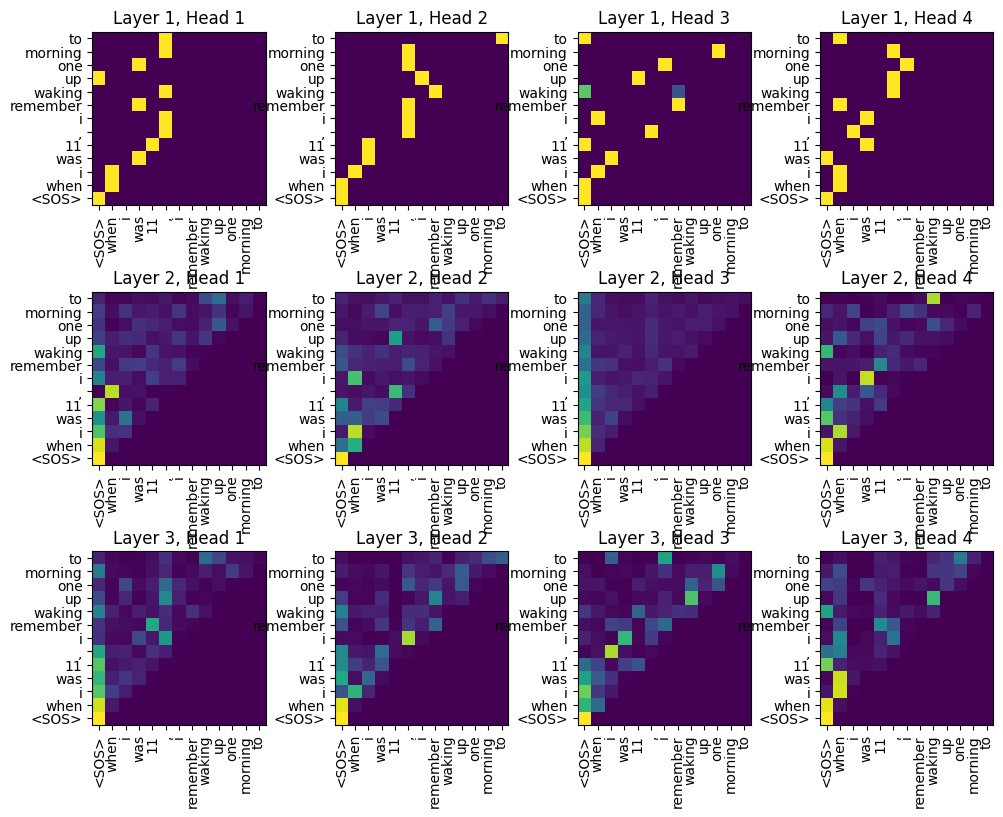

In [73]:
# Attention visualization helper
def plot_attention_maps(tokens_x, attn_maps, idx=0, tokens_y=None):
    if tokens_y is None:
        tokens_y = tokens_x
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin="lower", vmin=0)
            ax[row][column].set_xticks(list(range(len(tokens_x))))
            ax[row][column].set_xticklabels(tokens_x, rotation=90)
            ax[row][column].set_yticks(list(range(len(tokens_y))))
            ax[row][column].set_yticklabels(tokens_y)
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

VIS_MODEL = model
VIS_DATASET = dev_dataset
VIS_SRC_VOCAB = tr_vocab
VIS_TGT_VOCAB = en_vocab
SAMPLE_IDX = 0
MAX_TOKENS = 12

src_tokens = VIS_DATASET.src_sentences[SAMPLE_IDX][:MAX_TOKENS]
tgt_tokens = VIS_DATASET.tgt_sentences[SAMPLE_IDX][:MAX_TOKENS]
src_ids = torch.tensor(VIS_SRC_VOCAB.encode(src_tokens)).unsqueeze(0).to(device)
tgt_ids = torch.tensor(VIS_TGT_VOCAB.encode(tgt_tokens)).unsqueeze(0).to(device)
tgt_input = tgt_ids[:, :-1]

src_mask, tgt_mask = create_masks(src_ids, tgt_input)

VIS_MODEL.eval()
with torch.no_grad():
    _, attn_maps = VIS_MODEL(src_ids, tgt_input, src_mask, tgt_mask, return_attn_maps=True)

tgt_labels = VIS_TGT_VOCAB.decode(tgt_input.squeeze(0).tolist())

print("Decoder self-attention")
plot_attention_maps(tgt_labels, attn_maps["decoder_self"], idx=0)


The decoder self‑attention maps show how each output token attends to previous
tokens when generating the translation.

Layer 1: Each token focuses on itself or nearby previous tokens, the model captures short‑range context.

Layer 2: Attention becomes more distributed. Model is combining information
from a wider window of earlier tokens.

Layer 3: Attention is more diffuse with distinct hotspots, which
suggests that different heads specialize in different tokens while others attend more globally. This reflects higher‑level sequence
dependencies in later layers.


# What to submit

As in previous assignments, you have several options on how you can make the submission. The important part is, we need to see your code and your results in order to be able to grade you properly.

- You can write the answers and experiment results to your notebook and turn it into a pdf and submit it.
- You can put your experiment results and explanations to a seperate file as a report, and submit this report and the notebook pdf together.
- As long as we can see your code and also the experiment results and answers, you will be fine.

# Late Policy
You may use up to 7 grace days over the course of the semester for the |assignments you will take. You can only use up to 3 grace days per assignment.


# Academic Integrity
All work on assignments must be done individually unless stated otherwise. Turning in someone else’s work, in whole or in part, as your own will be considered as a violation of academic integrity. Please note that the former condition also holds for the material found on the web as everything on the web has been written by someone else.

## Acknowledgements
Adapted from University of Toronto, Neural Networks and Deep Learning course (CSC413/2516).